<a href="https://colab.research.google.com/github/DJCordhose/deep-learning-crash-course-notebooks/blob/master/6.2-understanding-recurrent-neural-networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [0]:
tf.random.set_seed(42)

In [4]:
from tensorflow import keras
keras.__version__

'2.2.4-tf'

In [5]:
!nvidia-smi

Mon Feb 24 00:18:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Understanding recurrent neural networks

This notebook contains the code samples found in Chapter 6, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---

[...]

## A first recurrent layer in Keras

The process we just naively implemented in Numpy corresponds to an actual Keras layer: the `SimpleRNN` layer:


In [0]:
from tensorflow.keras.layers import SimpleRNN

There is just one minor difference: `SimpleRNN` processes batches of sequences, like all other Keras layers, not just a single sequence like 
in our Numpy example. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, 
input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor 
argument. Let's take a look at an example:

In [0]:
Embeddin

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=32))
model.add(SimpleRNN(unit=32))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [11]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

In [12]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [13]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
17465344/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [50]:
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32,
                    dropout=0.1,
                    recurrent_dropout=0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_17 (SimpleRNN)    (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


In [0]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

In [52]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(input_train, y_train,
                    epochs=20,
                    # batch_size=128,
                    batch_size=1024,
                    callbacks=[callback],
                    validation_data=(input_test, y_test)
#                     validation_split=0.2
                   )

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 14s 563us/sample - loss: 0.7097 - accuracy: 0.5101 - val_loss: 0.6861 - val_accuracy: 0.5566
Epoch 2/20
25000/25000 [==============================] - 13s 501us/sample - loss: 0.6915 - accuracy: 0.5474 - val_loss: 0.6784 - val_accuracy: 0.6046
Epoch 3/20
25000/25000 [==============================] - 13s 518us/sample - loss: 0.6778 - accuracy: 0.5729 - val_loss: 0.6746 - val_accuracy: 0.6070
Epoch 4/20
25000/25000 [==============================] - 13s 515us/sample - loss: 0.6658 - accuracy: 0.6081 - val_loss: 0.6646 - val_accuracy: 0.6626
Epoch 5/20
25000/25000 [==============================] - 13s 517us/sample - loss: 0.6473 - accuracy: 0.6498 - val_loss: 0.6414 - val_accuracy: 0.6964
Epoch 6/20
25000/25000 [==============================] - 13s 504us/sample - loss: 0.6147 - accuracy: 0.6979 - val_loss: 0.6188 - val_accuracy: 0.7002
Epoch 7/20
25000/25000 [====================

Let's display the training and validation loss and accuracy:

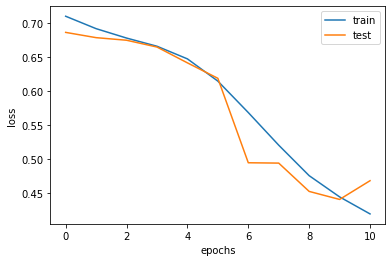

In [53]:
import matplotlib.pyplot as plt

# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

plt.legend(['train', 'test'])

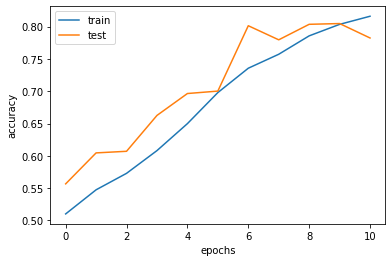

In [54]:
import matplotlib.pyplot as plt

# plt.yscale('log')
plt.ylabel("accuracy")
plt.xlabel("epochs")

plt.plot(history.history['accuracy']);
plt.plot(history.history['val_accuracy']);

plt.legend(['train', 'test'])

As a reminder, in chapter 3, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small 
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is 
that our inputs only consider the first 500 words rather the full sequences -- 
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some 
more advanced layers.

[...]

## A concrete LSTM example in Keras

Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, 
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you 
having to spend time tuning parameters by hand.

In [21]:
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    # batch_size=128,
                    batch_size=1024,
                    validation_data=(input_test, y_test)
#                     validation_split=0.2
                   )

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 9s 352us/sample - loss: 0.6896 - accuracy: 0.5860 - val_loss: 0.6785 - val_accuracy: 0.6981
Epoch 2/10
25000/25000 [==============================] - 2s 97us/sample - loss: 0.5950 - accuracy: 0.7457 - val_loss: 0.5223 - val_accuracy: 0.7744
Epoch 3/10
25000/25000 [==============================] - 2s 99us/sample - loss: 0.4434 - accuracy: 0.8184 - val_loss: 0.4108 - val_accuracy: 0.8291
Epoch 4/10
25000/25000 [==============================] - 2s 99us/sample - loss: 0.3359 - accuracy: 0.8729 - val_loss: 0.3490 - val_accuracy: 0.8529
Epoch 5/10
25000/25000 [==============================] - 2s 97us/sample - loss: 0.2656 - accuracy: 0.9022 - val_loss: 0.3265 - val_accuracy: 0.8616
Epoch 6/10
25000/25000 [==============================] - 2s 98us/sample - loss: 0.2201 - accuracy: 0.9221 - val_loss: 0.3155 - val_accuracy: 0.8699
Epoch 7/10
25000/25000 [==============================]

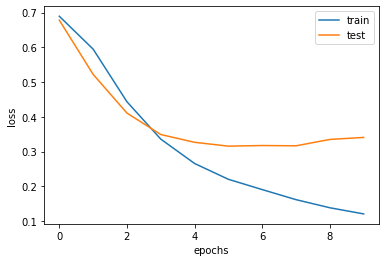

In [22]:
import matplotlib.pyplot as plt

# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

plt.legend(['train', 'test'])

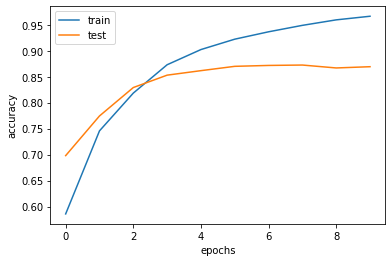

In [23]:
import matplotlib.pyplot as plt

# plt.yscale('log')
plt.ylabel("accuracy")
plt.xlabel("epochs")

plt.plot(history.history['accuracy']);
plt.plot(history.history['val_accuracy']);

plt.legend(['train', 'test'])

In [24]:
from tensorflow.keras.layers import GRU

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    # batch_size=128,
                    batch_size=1024,
                    validation_data=(input_test, y_test)
#                     validation_split=0.2
                   )

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 4s 155us/sample - loss: 0.6894 - accuracy: 0.5630 - val_loss: 0.6812 - val_accuracy: 0.6233
Epoch 2/10
25000/25000 [==============================] - 3s 101us/sample - loss: 0.6490 - accuracy: 0.6824 - val_loss: 0.5862 - val_accuracy: 0.7150
Epoch 3/10
25000/25000 [==============================] - 2s 98us/sample - loss: 0.4588 - accuracy: 0.7895 - val_loss: 0.4009 - val_accuracy: 0.8239
Epoch 4/10
25000/25000 [==============================] - 2s 99us/sample - loss: 0.3179 - accuracy: 0.8656 - val_loss: 0.3785 - val_accuracy: 0.8310
Epoch 5/10
25000/25000 [==============================] - 3s 101us/sample - loss: 0.2669 - accuracy: 0.8942 - val_loss: 0.3366 - val_accuracy: 0.8634
Epoch 6/10
25000/25000 [==============================] - 2s 100us/sample - loss: 0.2202 - accuracy: 0.9164 - val_loss: 0.3316 - val_accuracy: 0.8611
Epoch 7/10
25000/25000 [============================

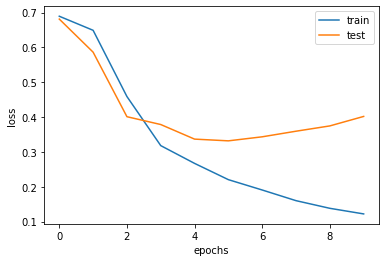

In [25]:
import matplotlib.pyplot as plt

# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

plt.legend(['train', 'test'])

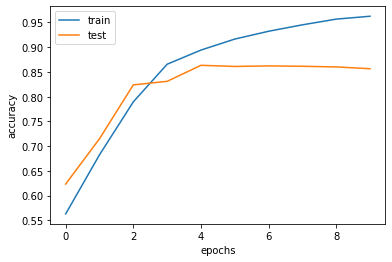

In [26]:
import matplotlib.pyplot as plt

# plt.yscale('log')
plt.ylabel("accuracy")
plt.xlabel("epochs")

plt.plot(history.history['accuracy']);
plt.plot(history.history['val_accuracy']);

plt.legend(['train', 'test'])

In [31]:
from tensorflow.keras.layers import GRU

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(GRU(32,
              dropout=0.4,
              recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    # batch_size=128,
                    batch_size=1024,
                    validation_data=(input_test, y_test)
#                     validation_split=0.2
                   )

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 30s 1ms/sample - loss: 0.6901 - accuracy: 0.5565 - val_loss: 0.6837 - val_accuracy: 0.6232
Epoch 2/10
25000/25000 [==============================] - 28s 1ms/sample - loss: 0.6589 - accuracy: 0.6656 - val_loss: 0.6238 - val_accuracy: 0.6764
Epoch 3/10
25000/25000 [==============================] - 27s 1ms/sample - loss: 0.5589 - accuracy: 0.7362 - val_loss: 0.5379 - val_accuracy: 0.7295
Epoch 4/10
25000/25000 [==============================] - 28s 1ms/sample - loss: 0.4736 - accuracy: 0.7873 - val_loss: 0.4945 - val_accuracy: 0.7575
Epoch 5/10
25000/25000 [==============================] - 27s 1ms/sample - loss: 0.4265 - accuracy: 0.8160 - val_loss: 0.4815 - val_accuracy: 0.7665
Epoch 6/10
25000/25000 [==============================] - 28s 1ms/sample - loss: 0.3993 - accuracy: 0.8334 - val_loss: 0.4737 - val_accuracy: 0.7737
Epoch 7/10
25000/25000 [==============================] 

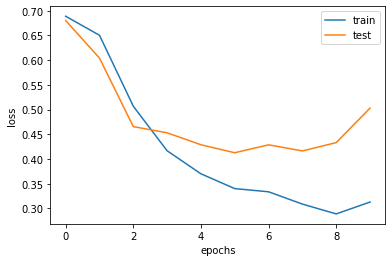

In [29]:
import matplotlib.pyplot as plt

# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

plt.legend(['train', 'test'])

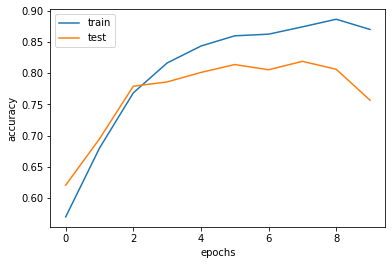

In [30]:
import matplotlib.pyplot as plt

# plt.yscale('log')
plt.ylabel("accuracy")
plt.xlabel("epochs")

plt.plot(history.history['accuracy']);
plt.plot(history.history['val_accuracy']);

plt.legend(['train', 'test'])